In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout

In [2]:
data = pd.read_csv("Clean_UoB_Set01_2025-01-02tapes.csv")

In [3]:
data.head()

,Time,Weighted_Price,Total_Size,Order_Number
0,10.881,267.0,1.0,1.0
1,11.067,269.0,1.0,1.0
2,11.222,267.0,2.0,1.0
3,12.338,270.0,2.0,1.0
4,13.733,267.0,3.0,1.0


In [4]:
data_copy = data[['Time','Weighted_Price']].copy()

In [5]:
data_copy

,Time,Weighted_Price
0,10.881,267.000000
1,11.067,269.000000
2,11.222,267.000000
3,12.338,270.000000
4,13.733,267.000000
...,...,...
18570,30594.830,285.333333
18571,30596.225,286.000000
18572,30598.085,287.500000
18573,30599.108,292.000000


In [6]:
max_time = data_copy['Time'].max()
min_time = data_copy['Time'].min()

# Calculate the correct range of bins, ensuring that we include the maximum time
# Add 10 to max_time to create a bin that includes the last data point if it falls exactly on a 10-second mark
time_bins = range(int(min_time) - (int(min_time) % 10), int(max_time) + 10, 10)

# Now we'll bin the data again using the corrected time bins
data_copy['time_bin'] = pd.cut(data_copy['Time'], bins=time_bins, right=False)

# Calculate the counts for each bin
corrected_bin_counts = data_copy['time_bin'].value_counts().sort_index()

# Converting the bin counts to a more readable string format
readable_corrected_bin_counts = corrected_bin_counts.rename(lambda x: f"{int(x.left)}-{int(x.right)}")
readable_corrected_bin_counts

time_bin
10-20          7
20-30          8
30-40          4
40-50          7
50-60          6
              ..
30550-30560    6
30560-30570    7
30570-30580    3
30580-30590    9
30590-30600    7
Name: count, Length: 3059, dtype: int64

In [7]:
def resample_and_adjust_using_original_times(df, target_count):
    # Creating a new column 'Time_bin' to convert 'Time' values into 10-second bins
    df['Time_bin'] = (df['Time'] // 10 * 10).astype(int)
    
    all_time_bins = range(df['Time_bin'].min(), df['Time_bin'].max() + 10, 10)
    grouped = df.groupby('Time_bin')

    new_records = []
    last_known_price = None 
    
    # Iterating through all possible time bins
    for time_bin in all_time_bins:
        # If the current time bin exists within the grouped data
        if time_bin in grouped.groups:
            group = grouped.get_group(time_bin)
            times = group['Time'].values
            prices = group['Weighted_Price'].values
            # If the prices array is not empty, update the last known price
            if len(prices) > 0:
                last_known_price = prices[-1]
        else:
            group = None 
            
        # If the current time bin is empty or has only one price data point
        if group is None or len(prices) == 0:
            prices = np.full(target_count, last_known_price)
            times = np.linspace(time_bin, time_bin + 9, num=target_count)
        elif len(prices) == 1:
            times = np.linspace(time_bin, time_bin + 9, num=target_count)
            prices = np.full(target_count, last_known_price)
        else:
            # If there are fewer data points than the target count, additional points will be added
            while len(prices) < target_count:
                time_diffs = np.diff(times)
                idx_to_fill = np.argmax(time_diffs)
                new_time = (times[idx_to_fill] + times[idx_to_fill + 1]) / 2
                new_price = (prices[idx_to_fill] + prices[idx_to_fill + 1]) / 2
                times = np.insert(times, idx_to_fill + 1, new_time)
                prices = np.insert(prices, idx_to_fill + 1, new_price)
            # If there are multiple data points within the time bin, proceed with normal processing
            while len(prices) > target_count:
                time_diffs = np.diff(times)
                idx_to_merge = np.argmin(time_diffs)
                new_time = (times[idx_to_merge] + times[idx_to_merge + 1]) / 2
                new_price = (prices[idx_to_merge] + prices[idx_to_merge + 1]) / 2
                times = np.delete(times, [idx_to_merge, idx_to_merge + 1])
                times = np.insert(times, idx_to_merge, new_time)
                prices = np.delete(prices, [idx_to_merge, idx_to_merge + 1])
                prices = np.insert(prices, idx_to_merge, new_price)
         # Add the processed data to the results list          
        new_records.extend(zip(times, prices))

    new_df = pd.DataFrame(new_records, columns=['Time', 'Weighted_Price'])
    new_df.sort_values('Time', inplace=True)
    return new_df

processed_df = resample_and_adjust_using_original_times(data_copy, 6)

In [8]:
processed_df

,Time,Weighted_Price
0,10.8810,267.000000
1,11.1445,268.000000
2,12.3380,270.000000
3,13.7330,267.000000
4,18.3210,265.000000
...,...,...
18349,30591.2960,288.250000
18350,30594.8300,285.333333
18351,30596.2250,286.000000
18352,30598.0850,287.500000


In [9]:
price = processed_df['Weighted_Price'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price)

In [10]:
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [11]:
time_step = 108

In [12]:
X, y = create_dataset(scaled_data, time_step)

In [13]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [14]:
total_len = len(X)
train_ratio = 0.6

non_train_ratio = 0.4
valid_test_ratio = 0.5 

train_index = int(train_ratio * total_len)
non_train_index = int(non_train_ratio * total_len / 2)

X_train = X[:train_index]
y_train = y[:train_index]

X_valid = X[train_index:train_index + non_train_index]
y_valid = y[train_index:train_index + non_train_index]

X_test = X[train_index + non_train_index:]
y_test = y[train_index + non_train_index:]

In [45]:
processed_df[14595:14605]

,Weighted_Price
Time,
1970-01-01 06:45:35.651000,286.00
1970-01-01 06:45:37.015000,279.75
1970-01-01 06:45:38.503000,290.00
1970-01-01 06:45:43.494000,294.00
1970-01-01 06:45:44.486000,294.00
1970-01-01 06:45:45.439250,292.75
1970-01-01 06:45:46.392500,291.50
1970-01-01 06:45:48.299000,289.00
1970-01-01 06:45:48.981000,289.00


In [15]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.0473 - val_loss: 0.0049
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0039 - val_loss: 0.0058
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0028 - val_loss: 0.0065
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 9/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 11/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 12/50
172/172 ━━━━━━━━━━━━━━━━━━━━

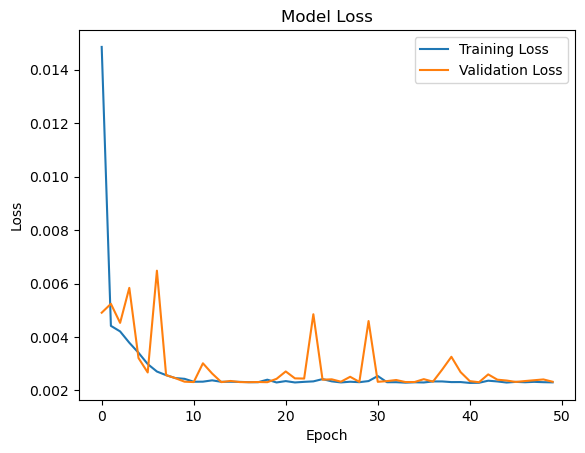

In [18]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')  # Add label for training loss plot
plt.plot(history.history['val_loss'], label='Validation Loss')  # Add label for validation loss plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # This line creates the legend based on the provided labels
plt.title('Model Loss')  # Set the title of the plot
plt.show()

In [ ]:
processed_df['Time'] = pd.to_datetime(processed_df['Time'], unit='s')
processed_df.set_index('Time',inplace=True)

In [47]:
processed_df[train_index+non_train_index+time_step:train_index+non_train_index+time_step+6].index

DatetimeIndex(['1970-01-01 06:48:38.613000', '1970-01-01 06:48:38.954000',
               '1970-01-01 06:48:40.535000', '1970-01-01 06:48:42.178000',
               '1970-01-01 06:48:44.224000', '1970-01-01 06:48:45.185000'],
              dtype='datetime64[ns]', name='Time', freq=None)

In [57]:
from datetime import timedelta

base_time = processed_df.index[train_index+non_train_index+time_step]
next_10_sec = base_time.ceil('10S')
new_batch_start_pos = processed_df.index.searchsorted(next_10_sec)
new_start_index = new_batch_start_pos - (new_batch_start_pos % 6)
index_difference = new_start_index - processed_df.index.get_loc(base_time)

In [51]:
predictions = []
all_results = pd.DataFrame()
for i in range(index_difference, len(X_test), 6):
    X_batch = X_test[i:i+6]
    forecast_values = model.predict(X_batch)
    forecast_values = scaler.inverse_transform(forecast_values)
    forecast_index = processed_df[train_index+non_train_index+time_step+i:train_index+non_train_index+time_step+i+6].index
    forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=['Forecasted_Price'])
    max_price = forecast_df['Forecasted_Price'].max()
    min_price = forecast_df['Forecasted_Price'].min()
    max_time = forecast_df['Forecasted_Price'].idxmax()
    min_time = forecast_df['Forecasted_Price'].idxmin()
    max_time = pd.to_datetime(max_time)
    min_time = pd.to_datetime(min_time)
    high_deviation = (abs(max_price - processed_df.loc[max_time]['Weighted_Price']) / processed_df.loc[max_time]['Weighted_Price'])
    low_deviation = (abs(min_price - processed_df.loc[min_time]['Weighted_Price'] ) / processed_df.loc[min_time]['Weighted_Price'])
    # Compare the time when the highest point and the lowest point occur and return the decision value
    decision = 1 if min_time < max_time else 2
    act_buy = False if min_price <  (1-low_deviation)*processed_df.loc[min_time]['Weighted_Price']  else True
    act_sell = False if max_price >  (1+high_deviation)*processed_df.loc[max_time]['Weighted_Price'] else True
    result = pd.DataFrame({
    'Highest_Price': [max_price],  
    'Lowest_Price': [min_price],
    'High_deviation': [high_deviation],
    'Low_deviation': [low_deviation],
    'Decision': [decision],
    'act_buy': [act_buy],
    'act_sell': [act_sell]
}, index=[max_time])  
    all_results = pd.concat([all_results, result])
    predictions.extend(forecast_values)  

predictions = np.array(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [52]:
all_results

,Highest_Price,Lowest_Price,High_deviation,Low_deviation,Decision,act_buy,act_sell
1970-01-01 06:48:42.178,291.375488,279.603027,0.011720,0.009397,2,True,True
1970-01-01 06:48:59.755,287.822052,279.027039,0.000618,0.005251,1,True,True
1970-01-01 06:49:03.568,287.411194,276.218567,0.012011,0.008097,2,True,True
1970-01-01 06:49:16.092,280.788300,275.961212,0.006410,0.001949,1,True,True
1970-01-01 06:49:21.827,281.618835,277.102142,0.002202,0.006802,2,True,True
...,...,...,...,...,...,...,...
1970-01-01 08:29:18.281,291.348633,285.526703,0.012378,0.001848,1,True,True
1970-01-01 08:29:21.226,293.670868,288.473083,0.005722,0.023544,2,True,True
1970-01-01 08:29:30.402,293.854736,288.654266,0.020329,0.000535,2,True,True
1970-01-01 08:29:49.095,293.000214,281.494324,0.020907,0.029330,1,True,True


In [40]:
rmse = np.sqrt(mean_squared_error(processed_df[train_index + non_train_index+time_step:], predictions))
print('Root Mean Squared Error:', rmse)
from sklearn.metrics import r2_score
r_squared = r2_score(processed_df[train_index + non_train_index+time_step:], predictions)
print('R² Score:', r_squared)

Root Mean Squared Error: 2.8934064339913266
R² Score: 0.6923472846657821


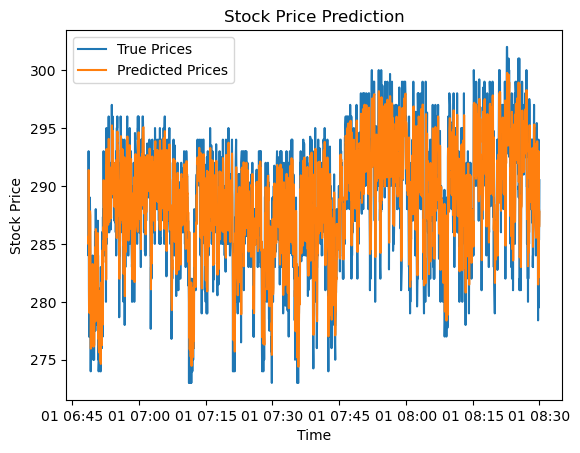

In [25]:
plt.plot(processed_df[train_index + non_train_index+time_step:].index, processed_df[train_index + non_train_index+time_step:], label='True Prices')
plt.plot(processed_df[train_index + non_train_index+time_step:].index, predictions, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [53]:
initial_capital = 5000
transaction_num = 1
hold_stocks = False
transaction_result = []
stock_num = 0


for index, row in all_results.iterrows():
    operation = row['Decision']
    highest_price = row['Highest_Price']
    lowest_price = row['Lowest_Price']
    act_buy = row['act_buy']
    act_sell = row['act_sell']
    
    if highest_price-lowest_price >= 0.01 and operation == 1:
        
        if  act_buy == True and act_sell == True  and initial_capital >= highest_price:

            initial_capital -= transaction_num * lowest_price
            stock_num += transaction_num
            initial_capital += stock_num*highest_price
            sell_num = stock_num
            stock_num = 0
            if stock_num != 0:
                hold_stocks = True
            else:
                hold_stocks = False
            transaction_result.append({'operation': 'buy first and sell all', 'buy price':lowest_price,'sell price':highest_price ,'sell number':sell_num ,'buy_num':transaction_num})

        if  act_buy == False and act_sell == True   and hold_stocks == True :

            initial_capital += stock_num*highest_price
            sell_num = stock_num
            stock_num = 0
            if stock_num != 0:
                hold_stocks = True
            else:
                hold_stocks = False
            transaction_result.append({'operation': 'buy faild only sell', 'buy price': 0,'sell price': highest_price,'sell number':sell_num ,'buy_num': 0 })

        if  act_buy == False and act_sell == True  and initial_capital >= highest_price :
            initial_capital -= transaction_num * lowest_price
            stock_num += transaction_num
            if stock_num != 0:
                hold_stocks = True
            else:
                hold_stocks = False
            transaction_result.append({'operation': 'sell faild only buy', 'buy price':lowest_price ,'sell price': 0,'sell number':0 ,'buy_num': transaction_num })

        if  act_buy == False and act_sell == False:
            transaction_result.append({'operation': 'sell faild and buy faild', 'buy price':0 ,'sell price': 0,'sell number':0 ,'buy_num': 0 })

transaction_result_df = pd.DataFrame(transaction_result)
print(transaction_result_df)

# Calculate final capital and profit
final_capital = initial_capital
profit = final_capital - 5000
Profitability = profit/5000
profitability_percent = "{:.4f}%".format(Profitability * 100)
print(f'capital at closing：{final_capital}')
print(f'total_profit：{profit}')
print(f'Profitability：{profitability_percent}')

                  operation   buy price  sell price  sell number  buy_num
0    buy first and sell all  279.027039  287.822052            1        1
1    buy first and sell all  275.961212  280.788300            1        1
2    buy first and sell all  281.653717  283.261078            1        1
3    buy first and sell all  278.864380  284.705505            1        1
4    buy first and sell all  278.309357  286.279144            1        1
..                      ...         ...         ...          ...      ...
291  buy first and sell all  290.895233  293.202484            1        1
292  buy first and sell all  286.583466  294.129730            1        1
293  buy first and sell all  285.526703  291.348633            1        1
294  buy first and sell all  281.494324  293.000214            1        1
295  buy first and sell all  282.118195  287.990997            1        1

[296 rows x 5 columns]
capital at closing：6510.050109863281
total_profit：1510.0501098632812
Profitability：30.20